In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replace 'fr1-xyz.tgz' with the exact filename if it's different
!cp /content/drive/MyDrive/rgbd_dataset_freiburg1_xyz.tgz /content/
# -x: extract, -z: decompress, -v: verbose (show files), -f: from file
!tar -xzvf /content/rgbd_dataset_freiburg1_xyz.tgz


rgbd_dataset_freiburg1_xyz/
rgbd_dataset_freiburg1_xyz/accelerometer.txt
rgbd_dataset_freiburg1_xyz/rgb/
rgbd_dataset_freiburg1_xyz/rgb/1305031107.143260.png
rgbd_dataset_freiburg1_xyz/rgb/1305031125.650575.png
rgbd_dataset_freiburg1_xyz/rgb/1305031106.711508.png
rgbd_dataset_freiburg1_xyz/rgb/1305031119.747193.png
rgbd_dataset_freiburg1_xyz/rgb/1305031114.211303.png
rgbd_dataset_freiburg1_xyz/rgb/1305031103.743326.png
rgbd_dataset_freiburg1_xyz/rgb/1305031124.249327.png
rgbd_dataset_freiburg1_xyz/rgb/1305031103.543444.png
rgbd_dataset_freiburg1_xyz/rgb/1305031124.850535.png
rgbd_dataset_freiburg1_xyz/rgb/1305031105.211268.png
rgbd_dataset_freiburg1_xyz/rgb/1305031110.311404.png
rgbd_dataset_freiburg1_xyz/rgb/1305031107.343509.png
rgbd_dataset_freiburg1_xyz/rgb/1305031112.043270.png
rgbd_dataset_freiburg1_xyz/rgb/1305031107.411271.png
rgbd_dataset_freiburg1_xyz/rgb/1305031120.315196.png
rgbd_dataset_freiburg1_xyz/rgb/1305031106.075330.png
rgbd_dataset_freiburg1_xyz/rgb/1305031114.57923

--- Step 1: Setting up environment ---

--- Step 2: Defining data association functions ---

--- Step 3: Loading and associating dataset files ---
Found 798 associated RGB-Depth image pairs.

--- Step 4: Running Visual Odometry pipeline ---


Processing Sequence:   0%|          | 0/797 [00:00<?, ?it/s]


--- Step 5: Visualizing Odometry Results ---


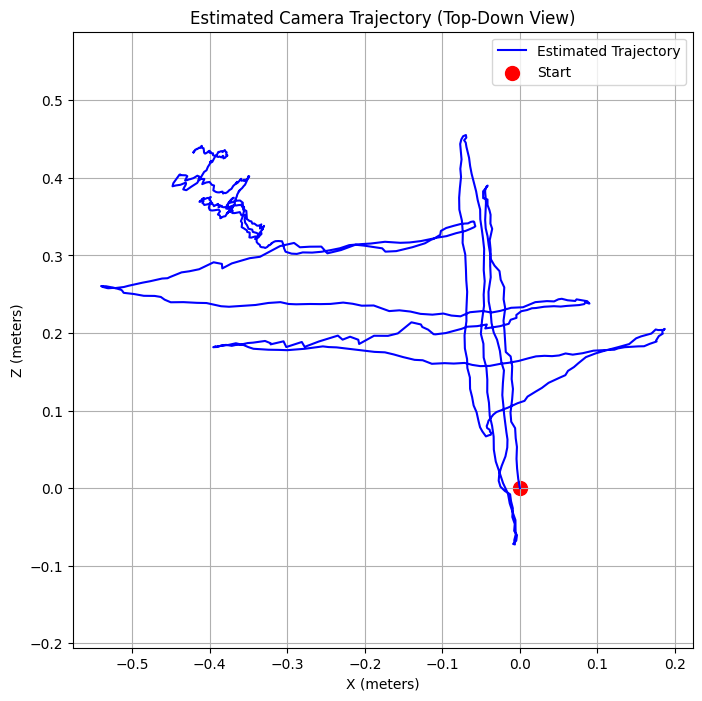


✅ Visual Odometry complete.
Final estimated position (X, Y, Z): (-0.42, -0.04, 0.43) meters


In [ ]:
# ==============================================================================
# STEP 1: SETUP AND IMPORTS
# ==============================================================================
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("--- Step 1: Setting up environment ---")

# ==============================================================================
# STEP 2: DATA ASSOCIATION FUNCTIONS FOR TUM DATASET
# ==============================================================================
print("\n--- Step 2: Defining data association functions ---")

def read_file_list(filename):
    """Reads a TUM-format file and returns a list of (timestamp, path) tuples."""
    with open(filename) as file:
        data = file.read()
        lines = data.replace(",", " ").replace("\t", " ").split("\n")
        lines = [line for line in lines if not line.startswith('#') and len(line) > 0]
        return [(float(line.split()[0]), line.split()[1]) for line in lines]

def associate(first_list, second_list, max_difference=0.02):
    """Associates two lists of (timestamp, path) tuples based on closest timestamp."""
    first_dict = dict(first_list)
    second_dict = dict(second_list)
    matches = []
    for timestamp, path1 in first_list:
        if timestamp in second_dict:
            matches.append((timestamp, path1, timestamp, second_dict[timestamp]))
        else:
            best_match_timestamp = min(second_dict.keys(), key=lambda t: abs(t - timestamp))
            if abs(best_match_timestamp - timestamp) < max_difference:
                matches.append((timestamp, path1, best_match_timestamp, second_dict[best_match_timestamp]))
    return matches

# ==============================================================================
# STEP 3: PREPARE THE DATA
# ==============================================================================
print("\n--- Step 3: Loading and associating dataset files ---")

# --- Configuration ---
DATASET_PATH = 'rgbd_dataset_freiburg1_xyz/'
# The TUM dataset depth images are stored as 16-bit PNGs.
# The depth value is obtained by dividing the pixel value by 5000.0.
DEPTH_SCALING_FACTOR = 5000.0
# Camera intrinsics for the Freiburg 1 sensor
K = np.array([
    [517.3, 0, 318.6],
    [0, 516.5, 255.3],
    [0, 0, 1]
], dtype=np.float32)

# --- Load and associate ---
rgb_list = read_file_list(os.path.join(DATASET_PATH, 'rgb.txt'))
depth_list = read_file_list(os.path.join(DATASET_PATH, 'depth.txt'))
matches = associate(rgb_list, depth_list)

print(f"Found {len(matches)} associated RGB-Depth image pairs.")

# ==============================================================================
# STEP 4: RUN VISUAL ODOMETRY
# ==============================================================================
print("\n--- Step 4: Running Visual Odometry pipeline ---")

# --- Initialize ORB Detector and BFMatcher ---
orb = cv2.ORB_create(nfeatures=2000)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# --- Odometry Variables ---
R_total = np.eye(3)
T_total = np.zeros((3, 1))
trajectory = [T_total.flatten()]

# --- Main Loop ---
for i in tqdm(range(len(matches) - 1), desc="Processing Sequence"):
    # 1. LOAD CONSECUTIVE FRAMES
    # Frame 1 data
    ts1, rgb_path1, _, depth_path1 = matches[i]
    img0_bgr = cv2.imread(os.path.join(DATASET_PATH, rgb_path1))
    depth0_raw = cv2.imread(os.path.join(DATASET_PATH, depth_path1), cv2.IMREAD_UNCHANGED)

    # Frame 2 data
    ts2, rgb_path2, _, _ = matches[i+1]
    img1_bgr = cv2.imread(os.path.join(DATASET_PATH, rgb_path2))

    if img0_bgr is None or depth0_raw is None or img1_bgr is None: continue

    depth_map = depth0_raw.astype(np.float32) / DEPTH_SCALING_FACTOR
    img0_gray = cv2.cvtColor(img0_bgr, cv2.COLOR_BGR2GRAY)
    img1_gray = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)

    # 2. FEATURE MATCHING (ORB)
    kp0, des0 = orb.detectAndCompute(img0_gray, None)
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    if des0 is None or des1 is None: continue

    orb_matches = bf.match(des0, des1)
    if len(orb_matches) < 20: continue

    # 3. GET 3D POINTS FROM DEPTH MAP
    pts_2d = np.float32([kp0[m.queryIdx].pt for m in orb_matches])
    pts_3d = []
    pts_2d_filtered = []

    for idx, pt in enumerate(pts_2d):
        x, y = int(pt[0]), int(pt[1])
        if 0 <= y < depth_map.shape[0] and 0 <= x < depth_map.shape[1]:
            depth_val = depth_map[y, x]
            if depth_val > 0.1: # Filter out invalid depth
                # Unproject 2D point to 3D space
                Z = depth_val
                X = (x - K[0, 2]) * Z / K[0, 0]
                Y = (y - K[1, 2]) * Z / K[1, 1]
                pts_3d.append([X, Y, Z])
                # Keep the corresponding 2D point from the *second* image
                pts_2d_filtered.append(kp1[orb_matches[idx].trainIdx].pt)

    if len(pts_3d) < 10: continue

    # 4. ESTIMATE POSE WITH SOLVEPNP
    # We now have 3D points from the first frame and their 2D projections in the second frame.
    # solvePnP finds the rotation and translation that maps the 3D points to their 2D projections.
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        np.array(pts_3d, dtype=np.float32),
        np.array(pts_2d_filtered, dtype=np.float32),
        K, None
    )

    if not success: continue

    R, _ = cv2.Rodrigues(rvec) # Convert rotation vector to rotation matrix

    # 5. ACCUMULATE ODOMETRY
    # Note: solvePnP gives the transformation from world (frame 1) to camera (frame 2).
    # To get the motion of the camera, we need the inverse.
    R_inv = R.T
    t_inv = -R.T @ tvec

    T_total = T_total + R_total @ t_inv
    R_total = R_inv @ R_total

    trajectory.append(T_total.flatten())

# ==============================================================================
# STEP 5: VISUALIZE FINAL RESULTS
# ==============================================================================
print("\n--- Step 5: Visualizing Odometry Results ---")

trajectory = np.array(trajectory)

plt.figure(figsize=(8, 8))
plt.plot(trajectory[:, 0], trajectory[:, 2], 'b-', label='Estimated Trajectory')
plt.scatter(trajectory[0, 0], trajectory[0, 2], c='r', marker='o', s=100, label='Start')
plt.title('Estimated Camera Trajectory (Top-Down View)')
plt.xlabel('X (meters)')
plt.ylabel('Z (meters)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

print(f"\n✅ Visual Odometry complete.")
print(f"Final estimated position (X, Y, Z): ({T_total[0,0]:.2f}, {T_total[1,0]:.2f}, {T_total[2,0]:.2f}) meters")

In [ ]:
# ================================================================================
# STEP 1: SETUP AND IMPORTS
# ==============================================================================
import os
import numpy as np
import torch
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

print("--- Step 1: Setting up environment ---")

# ==============================================================================
# STEP 2: DEFINE DATA LOADING AND CORE FUNCTIONS
# ==============================================================================
print("\n--- Step 2: Defining core functions ---")
DEFAULT_ZOE_MODEL = "Intel/zoedepth-nyu-kitti"

### --- Functions for TUM Dataset Association (NEW) --- ###
def read_file_list(filename):
    """Reads a TUM-format file and returns a list of (timestamp, path) tuples."""
    with open(filename) as file:
        data = file.read()
        lines = data.replace(",", " ").replace("\t", " ").split("\n")
        lines = [line for line in lines if not line.startswith('#') and len(line) > 0]
        return [(float(line.split()[0]), line.split()[1]) for line in lines]

def associate(first_list, second_list, max_difference=0.02):
    """Associates two lists of (timestamp, path) tuples based on closest timestamp."""
    first_dict = dict(first_list)
    second_dict = dict(second_list)
    matches = []
    for timestamp, path1 in first_list:
        if timestamp in second_dict:
            matches.append((timestamp, path1, timestamp, second_dict[timestamp]))
        else:
            best_match_timestamp = min(second_dict.keys(), key=lambda t: abs(t - timestamp))
            if abs(best_match_timestamp - timestamp) < max_difference:
                matches.append((timestamp, path1, best_match_timestamp, second_dict[best_match_timestamp]))
    return matches

### --- Functions for ZoeDepth Model (from your script) --- ###
def load_zoedepth_hf(model_id=DEFAULT_ZOE_MODEL, device="cuda"):
    """Loads the ZoeDepth model and processor from Hugging Face."""
    print(f"Loading ZoeDepth model '{model_id}' on device '{device}'...")
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForDepthEstimation.from_pretrained(model_id).to(device).eval()
    return processor, model

def zoedepth_predict_batch_hf(processor, model, frames, device="cuda"):
    """Generates depth predictions for a batch of images."""
    pil_imgs = [Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB)) for f in frames]
    inputs = processor(images=pil_imgs, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs)
    pred = out.predicted_depth.detach().cpu().numpy()
    if pred.ndim == 4 and pred.shape[1] == 1:
        pred = pred[:, 0, :, :]

    depths = []
    for i in range(pred.shape[0]):
        h, w = frames[i].shape[:2]
        d_resized = cv2.resize(pred[i], (w, h), interpolation=cv2.INTER_LINEAR)
        depths.append(d_resized.astype(np.float32))
    return depths

# ==============================================================================
# STEP 3: DEFINE METRIC CALCULATION FUNCTION
# ==============================================================================
def compute_depth_metrics(pred, gt):
    """Computes standard depth estimation metrics."""
    # Define a valid range for TUM indoor dataset (e.g., 0 to 8 meters)
    mask = (gt > 0) & (gt <= 8.0) # Using 8m cap for TUM
    if not np.any(mask):
        return None

    pred_masked = pred[mask]
    gt_masked = gt[mask]

    # Threshold accuracy
    thresh = np.maximum((gt_masked / pred_masked), (pred_masked / gt_masked))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25**2).mean()
    a3 = (thresh < 1.25**3).mean()

    # Error metrics
    rmse = np.sqrt(((gt_masked - pred_masked) ** 2).mean())
    abs_rel = np.mean(np.abs(gt_masked - pred_masked) / gt_masked)

    return {'abs_rel': abs_rel, 'rmse': rmse, 'delta1': a1, 'delta2': a2, 'delta3': a3}

# ==============================================================================
# STEP 4: CONFIGURE AND RUN EVALUATION
# ==============================================================================
print("\n--- Step 4: Configuring and starting evaluation ---")

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
MAX_DEPTH = 8.0  # Max depth in meters for TUM evaluation
DATASET_PATH = 'rgbd_dataset_freiburg1_xyz/'
DEPTH_SCALING_FACTOR = 5000.0 # Crucial for TUM dataset

# --- Load Model and Associate Data ---
processor, model = load_zoedepth_hf(device=DEVICE)

print("Associating RGB and Depth images based on timestamps...")
rgb_list = read_file_list(os.path.join(DATASET_PATH, 'rgb.txt'))
depth_list = read_file_list(os.path.join(DATASET_PATH, 'depth.txt'))
matches = associate(rgb_list, depth_list)
print(f"Found {len(matches)} associated test samples.")

# --- Main Loop ---
all_metrics = []
for i in tqdm(range(0, len(matches), BATCH_SIZE), desc="Evaluating Batches"):
    batch_matches = matches[i : i + BATCH_SIZE]
    rgb_frames, gt_depths = [], []

    for match in batch_matches:
        # Unpack timestamps and paths from the match tuple
        _, rgb_rel_path, _, depth_rel_path = match

        rgb_path = os.path.join(DATASET_PATH, rgb_rel_path)
        depth_path = os.path.join(DATASET_PATH, depth_rel_path)

        rgb_img = cv2.imread(rgb_path)
        # Load TUM depth map and scale it correctly to get meters
        gt_depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype('float32') / DEPTH_SCALING_FACTOR

        if rgb_img is not None and gt_depth is not None:
            rgb_frames.append(rgb_img)
            gt_depths.append(gt_depth)

    if not rgb_frames: continue

    pred_depths = zoedepth_predict_batch_hf(processor, model, rgb_frames, device=DEVICE)

    for pred, gt in zip(pred_depths, gt_depths):
        # Median Scaling: Align prediction scale with ground truth scale
        scaling_mask = (gt > 0) & (gt <= MAX_DEPTH)
        if not np.any(scaling_mask):
            continue

        scale = np.median(gt[scaling_mask]) / np.median(pred[scaling_mask])
        pred_scaled = pred * scale
        pred_clipped = np.clip(pred_scaled, 0, MAX_DEPTH)

        metrics = compute_depth_metrics(pred_clipped, gt)
        if metrics:
            all_metrics.append(metrics)

# ==============================================================================
# STEP 5: DISPLAY FINAL RESULTS
# ==============================================================================
print("\n--- Step 5: Aggregating and displaying results ---")
if all_metrics:
    final_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}

    print("\n--- Evaluation Results ---")
    print(f"Total Samples Evaluated: {len(all_metrics)}")
    print("-" * 28)
    # Error Metrics (Lower is better)
    print(f"Abs Rel: {final_metrics['abs_rel']:.4f}")
    print(f"RMSE:    {final_metrics['rmse']:.4f}")
    # Accuracy Metrics (Higher is better)
    print(f"δ < 1.25:  {final_metrics['delta1']:.4f}")
    print(f"δ < 1.25²: {final_metrics['delta2']:.4f}")
    print(f"δ < 1.25³: {final_metrics['delta3']:.4f}")
    print("--------------------------")
else:
    print("No valid samples were evaluated. Please check dataset paths and content.")

--- Step 1: Setting up environment ---

--- Step 2: Defining core functions ---

--- Step 4: Configuring and starting evaluation ---
Loading ZoeDepth model 'Intel/zoedepth-nyu-kitti' on device 'cuda'...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

Associating RGB and Depth images based on timestamps...
Found 798 associated test samples.


Evaluating Batches:   0%|          | 0/100 [00:00<?, ?it/s]


--- Step 5: Aggregating and displaying results ---

--- Evaluation Results ---
Total Samples Evaluated: 798
----------------------------
Abs Rel: 0.1371
RMSE:    0.3172
δ < 1.25:  0.8748
δ < 1.25²: 0.9528
δ < 1.25³: 0.9834
--------------------------


--- Step 1: Setting up environment ---

--- Step 2: Defining helper functions for data and model ---

--- Step 3: Initializing models, detectors, and data ---
Loading ZoeDepth model 'Intel/zoedepth-nyu-kitti' on device 'cuda'...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

Associating RGB images based on timestamps...
Found 798 RGB images for processing.

--- Step 4: Running Visual Odometry and Speed Estimation pipeline ---


Processing Sequence:   0%|          | 0/797 [00:00<?, ?it/s]


--- Step 5: Visualizing Odometry and Speed Results ---


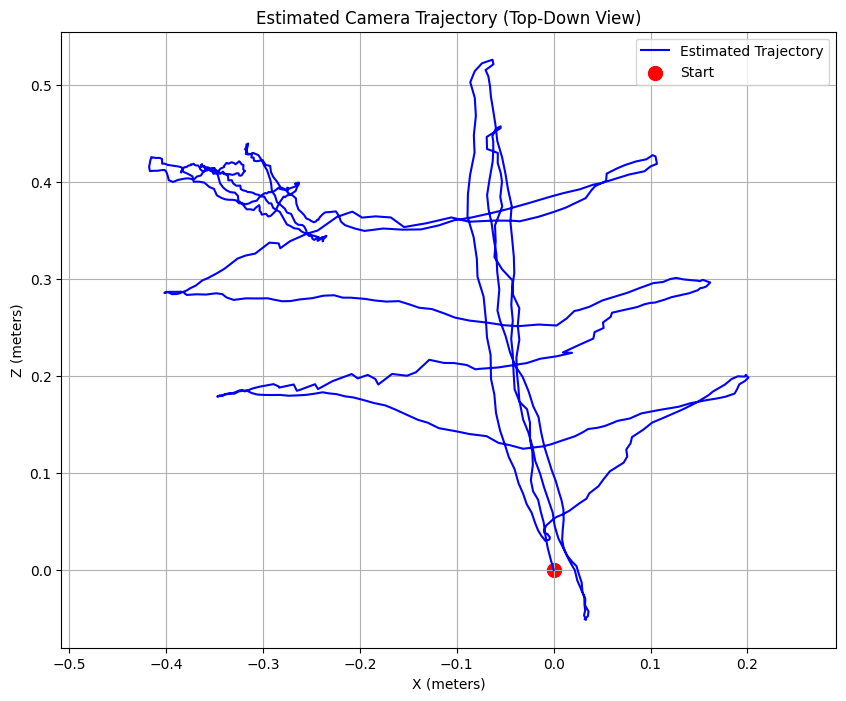

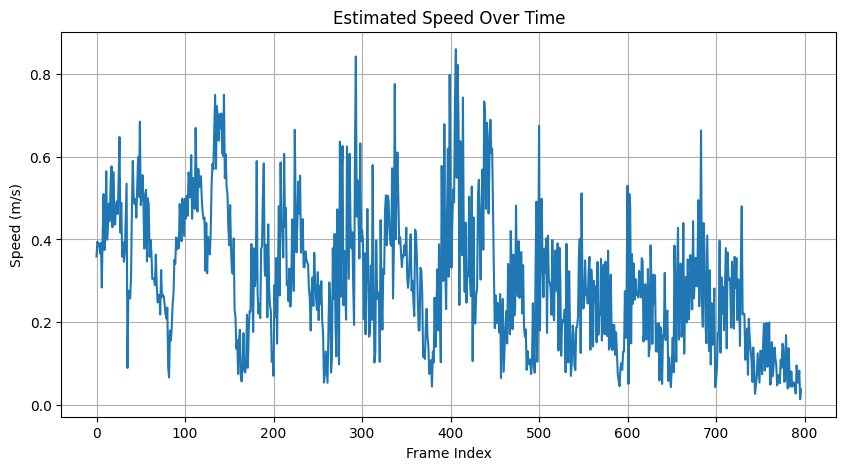


✅ Visual Odometry complete.
Final estimated position (X, Y, Z): (-0.38, -0.03, 0.41) meters
Average speed: 0.31 m/s


In [ ]:
# ==============================================================================
# STEP 1: SETUP AND IMPORTS
# ==============================================================================
import os
import numpy as np
import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

print("--- Step 1: Setting up environment ---")

# ==============================================================================
# STEP 2: DEFINE HELPER FUNCTIONS
# ==============================================================================
print("\n--- Step 2: Defining helper functions for data and model ---")

### --- Functions for TUM Dataset Association --- ###
def read_file_list(filename):
    """Reads a TUM-format file and returns a list of (timestamp, path) tuples."""
    with open(filename) as file:
        data = file.read()
        lines = data.replace(",", " ").replace("\t", " ").split("\n")
        lines = [line for line in lines if not line.startswith('#') and len(line) > 0]
        return [(float(line.split()[0]), line.split()[1]) for line in lines]

def associate(first_list, second_list, max_difference=0.02):
    """Associates two lists of (timestamp, path) tuples based on closest timestamp."""
    first_dict = dict(first_list)
    second_dict = dict(second_list)
    matches = []
    for timestamp, path1 in first_list:
        best_match_timestamp = min(second_dict.keys(), key=lambda t: abs(t - timestamp))
        if abs(best_match_timestamp - timestamp) < max_difference:
            matches.append((timestamp, path1, best_match_timestamp, second_dict[best_match_timestamp]))
    return matches

### --- Functions for ZoeDepth Model --- ###
DEFAULT_ZOE_MODEL = "Intel/zoedepth-nyu-kitti"

def load_zoedepth_hf(model_id=DEFAULT_ZOE_MODEL, device="cuda"):
    """Loads the ZoeDepth model and processor from Hugging Face."""
    print(f"Loading ZoeDepth model '{model_id}' on device '{device}'...")
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForDepthEstimation.from_pretrained(model_id).to(device).eval()
    return processor, model

def zoedepth_predict(processor, model, img_bgr, device="cuda"):
    """Generates a metric depth prediction for a single BGR image."""
    pil_img = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    inputs = processor(images=pil_img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs)
    # Resize to match original image size
    h, w = img_bgr.shape[:2]
    predicted_depth = torch.nn.functional.interpolate(
        out.predicted_depth.unsqueeze(1),
        size=(h, w),
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    return predicted_depth.cpu().numpy().astype(np.float32)

# ==============================================================================
# STEP 3: INITIALIZE MODELS, DETECTORS, AND DATA
# ==============================================================================
print("\n--- Step 3: Initializing models, detectors, and data ---")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Configuration ---
DATASET_PATH = 'rgbd_dataset_freiburg1_xyz/'
# Camera intrinsics for the Freiburg 1 sensor
K = np.array([
    [517.3, 0, 318.6],
    [0, 516.5, 255.3],
    [0, 0, 1]
], dtype=np.float32)

# --- Load Model and Detectors ---
zoe_processor, zoe_model = load_zoedepth_hf(device=DEVICE)
orb = cv2.ORB_create(nfeatures=2000)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# --- Load and Associate Data ---
print("Associating RGB images based on timestamps...")
rgb_list = read_file_list(os.path.join(DATASET_PATH, 'rgb.txt'))
matches = [(t, p) for t, p in rgb_list] # We only need the RGB images
print(f"Found {len(matches)} RGB images for processing.")

# ==============================================================================
# STEP 4: RUN VISUAL ODOMETRY & SPEED ESTIMATION
# ==============================================================================
print("\n--- Step 4: Running Visual Odometry and Speed Estimation pipeline ---")

# --- Odometry Variables ---
R_total = np.eye(3)
T_total = np.zeros((3, 1))
trajectory = [T_total.flatten()]
speeds = []

# --- Main Loop ---
for i in tqdm(range(len(matches) - 1), desc="Processing Sequence"):
    # 1. LOAD CONSECUTIVE FRAMES
    ts1, rgb_path1_rel = matches[i]
    ts2, rgb_path2_rel = matches[i+1]

    img0_bgr = cv2.imread(os.path.join(DATASET_PATH, rgb_path1_rel))
    img1_bgr = cv2.imread(os.path.join(DATASET_PATH, rgb_path2_rel))
    if img0_bgr is None or img1_bgr is None: continue

    # 2. PREDICT DEPTH FOR THE FIRST FRAME
    depth_map = zoedepth_predict(zoe_processor, zoe_model, img0_bgr, device=DEVICE)

    # 3. FEATURE MATCHING (ORB)
    img0_gray = cv2.cvtColor(img0_bgr, cv2.COLOR_BGR2GRAY)
    img1_gray = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
    kp0, des0 = orb.detectAndCompute(img0_gray, None)
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    if des0 is None or des1 is None: continue

    orb_matches = bf.match(des0, des1)
    if len(orb_matches) < 20: continue

    # 4. GET 3D POINTS FROM PREDICTED DEPTH
    pts_2d_img1 = np.float32([kp0[m.queryIdx].pt for m in orb_matches])
    pts_3d_cam1 = []
    pts_2d_img2_filtered = []

    for idx, pt in enumerate(pts_2d_img1):
        x, y = int(pt[0]), int(pt[1])
        if 0 <= y < depth_map.shape[0] and 0 <= x < depth_map.shape[1]:
            depth_val = depth_map[y, x]
            if depth_val > 0.1: # Filter out invalid depth
                Z = depth_val
                X = (x - K[0, 2]) * Z / K[0, 0]
                Y = (y - K[1, 2]) * Z / K[1, 1]
                pts_3d_cam1.append([X, Y, Z])
                pts_2d_img2_filtered.append(kp1[orb_matches[idx].trainIdx].pt)

    if len(pts_3d_cam1) < 10: continue

    # 5. ESTIMATE POSE WITH SOLVEPNP
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        np.array(pts_3d_cam1, dtype=np.float32),
        np.array(pts_2d_img2_filtered, dtype=np.float32),
        K, None
    )
    if not success: continue

    # 6. CALCULATE SPEED
    distance = np.linalg.norm(tvec)
    dt = ts2 - ts1
    if dt > 0:
        speed_mps = distance / dt
        speeds.append(speed_mps)

    # 7. ACCUMULATE ODOMETRY
    R, _ = cv2.Rodrigues(rvec)
    R_inv = R.T
    t_inv = -R.T @ tvec

    T_total = T_total + R_total @ t_inv
    R_total = R_inv @ R_total

    trajectory.append(T_total.flatten())

# ==============================================================================
# STEP 5: VISUALIZE FINAL RESULTS
# ==============================================================================
print("\n--- Step 5: Visualizing Odometry and Speed Results ---")

trajectory = np.array(trajectory)
speeds = np.array(speeds)

# Plot the 2D trajectory (top-down view)
plt.figure(figsize=(10, 8))
plt.plot(trajectory[:, 0], trajectory[:, 2], 'b-', label='Estimated Trajectory')
plt.scatter(trajectory[0, 0], trajectory[0, 2], c='r', marker='o', s=100, label='Start')
plt.title('Estimated Camera Trajectory (Top-Down View)')
plt.xlabel('X (meters)')
plt.ylabel('Z (meters)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Plot the speed over time
plt.figure(figsize=(10, 5))
plt.plot(speeds)
plt.title('Estimated Speed Over Time')
plt.xlabel('Frame Index')
plt.ylabel('Speed (m/s)')
plt.grid(True)
plt.show()

print(f"\n✅ Visual Odometry complete.")
print(f"Final estimated position (X, Y, Z): ({T_total[0,0]:.2f}, {T_total[1,0]:.2f}, {T_total[2,0]:.2f}) meters")
if len(speeds) > 0:
    print(f"Average speed: {np.mean(speeds):.2f} m/s")

--- Step 1: Setting up environment ---

--- Step 2: Defining helper functions for data, models, and evaluation ---

--- Step 3: Initializing models, detectors, and all data sources ---
Loading ZoeDepth model 'Intel/zoedepth-nyu-kitti' on device 'cuda'...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading and associating RGB, Depth, and Ground Truth data...
Found 798 associated RGB-Depth image pairs.

--- Running Odometry with Ground Truth Depth ---


GT Depth Odometry:   0%|          | 0/797 [00:00<?, ?it/s]


--- Running Odometry with ZoeDepth Predicted Depth ---


ZoeDepth Odometry:   0%|          | 0/797 [00:00<?, ?it/s]


--- Step 5: Evaluating trajectories against official ground truth ---


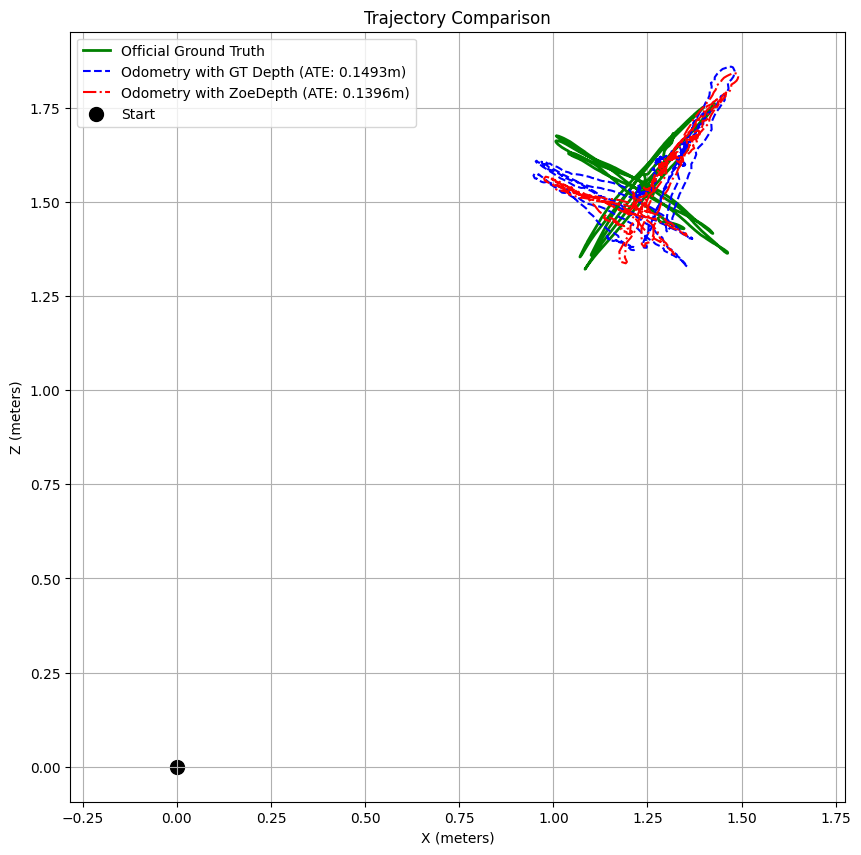


  NUMERICAL PERFORMANCE COMPARISON
Metric: Absolute Trajectory Error (ATE) RMSE
Lower is better.

Odometry with Ground Truth Depth: 0.1493 meters
Odometry with ZoeDepth:         0.1396 meters
----------------------------------------


In [ ]:
0# ==============================================================================
# STEP 1: SETUP AND IMPORTS
# ==============================================================================
import os
import numpy as np
import torch
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

print("--- Step 1: Setting up environment ---")

# ==============================================================================
# STEP 2: DEFINE ALL HELPER FUNCTIONS
# ==============================================================================
print("\n--- Step 2: Defining helper functions for data, models, and evaluation ---")

### --- Functions for TUM Dataset Association --- ###
def read_file_list(filename):
    """Reads a TUM-format file and returns a list of (timestamp, data) tuples."""
    with open(filename) as file:
        data = file.read()
        lines = data.replace(",", " ").replace("\t", " ").split("\n")
        lines = [line for line in lines if not line.startswith('#') and len(line) > 0]
        # For ground truth, data is [tx, ty, tz, qx, qy, qz, qw]
        if len(lines[0].split()) > 2:
            return [(float(line.split()[0]), [float(v) for v in line.split()[1:]]) for line in lines]
        # For rgb/depth, data is just the path
        else:
            return [(float(line.split()[0]), line.split()[1]) for line in lines]

def associate(first_list, second_list, max_difference=0.02):
    """Associates two lists of (timestamp, data) tuples based on closest timestamp."""
    first_dict = dict(first_list)
    second_dict = dict(second_list)
    matches = []
    for ts, data1 in first_list:
        best_match_ts = min(second_dict.keys(), key=lambda t: abs(t - ts))
        if abs(best_match_ts - ts) < max_difference:
            matches.append((ts, data1, best_match_ts, second_dict[best_match_ts]))
    return matches

### --- Functions for ZoeDepth Model --- ###
def load_zoedepth_hf(model_id="Intel/zoedepth-nyu-kitti", device="cuda"):
    print(f"Loading ZoeDepth model '{model_id}' on device '{device}'...")
    processor = AutoImageProcessor.from_pretrained(model_id)
    model = AutoModelForDepthEstimation.from_pretrained(model_id).to(device).eval()
    return processor, model

def zoedepth_predict(processor, model, img_bgr, device="cuda"):
    pil_img = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    inputs = processor(images=pil_img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs)
    h, w = img_bgr.shape[:2]
    predicted_depth = torch.nn.functional.interpolate(
        out.predicted_depth.unsqueeze(1), size=(h, w), mode="bicubic", align_corners=False
    ).squeeze()
    return predicted_depth.cpu().numpy().astype(np.float32)

### --- Functions for Evaluation --- ###
def align_trajectory(estimated_poses, gt_poses):
    """Aligns two trajectories using Umeyama's algorithm (translation and rotation)."""
    # Find centroids
    est_centroid = np.mean(estimated_poses, axis=0)
    gt_centroid = np.mean(gt_poses, axis=0)

    # Center the trajectories
    est_centered = estimated_poses - est_centroid
    gt_centered = gt_poses - gt_centroid

    # Compute covariance matrix
    H = est_centered.T @ gt_centered

    # SVD to find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # Handle reflection case
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # Find translation
    t = gt_centroid - (R @ est_centroid)

    # Align the estimated trajectory
    aligned_poses = (R @ estimated_poses.T).T + t
    return aligned_poses

def calculate_ate(aligned_poses, gt_poses):
    """Calculates the Absolute Trajectory Error (ATE) as RMSE."""
    errors = aligned_poses - gt_poses
    squared_errors = np.sum(errors**2, axis=1)
    rmse = np.sqrt(np.mean(squared_errors))
    return rmse

# ==============================================================================
# STEP 3: INITIALIZE AND PREPARE ALL DATA
# ==============================================================================
print("\n--- Step 3: Initializing models, detectors, and all data sources ---")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_PATH = 'rgbd_dataset_freiburg1_xyz/'
DEPTH_SCALING_FACTOR = 5000.0
K = np.array([[517.3, 0, 318.6], [0, 516.5, 255.3], [0, 0, 1]], dtype=np.float32)

# --- Load Model and Detectors ---
zoe_processor, zoe_model = load_zoedepth_hf(device=DEVICE)
orb = cv2.ORB_create(nfeatures=2000)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# --- Load and Associate Data ---
print("Loading and associating RGB, Depth, and Ground Truth data...")
rgb_list = read_file_list(os.path.join(DATASET_PATH, 'rgb.txt'))
depth_list = read_file_list(os.path.join(DATASET_PATH, 'depth.txt'))
gt_list = read_file_list(os.path.join(DATASET_PATH, 'groundtruth.txt'))
matches_rgb_depth = associate(rgb_list, depth_list)
print(f"Found {len(matches_rgb_depth)} associated RGB-Depth image pairs.")

# ==============================================================================
# STEP 4: RUN ODOMETRY PIPELINES
# ==============================================================================

### --- Method 1: Odometry with Ground Truth Depth --- ###
print("\n--- Running Odometry with Ground Truth Depth ---")
R_total_gt = np.eye(3)
T_total_gt = np.zeros((3, 1))
trajectory_gt_depth = {matches_rgb_depth[0][0]: T_total_gt.flatten()}

for i in tqdm(range(len(matches_rgb_depth) - 1), desc="GT Depth Odometry"):
    ts1, rgb_path1, _, depth_path1 = matches_rgb_depth[i]
    ts2, rgb_path2, _, _ = matches_rgb_depth[i+1]

    img0 = cv2.imread(os.path.join(DATASET_PATH, rgb_path1), cv2.IMREAD_GRAYSCALE)
    img1 = cv2.imread(os.path.join(DATASET_PATH, rgb_path2), cv2.IMREAD_GRAYSCALE)
    depth_raw = cv2.imread(os.path.join(DATASET_PATH, depth_path1), cv2.IMREAD_UNCHANGED)
    if img0 is None or img1 is None or depth_raw is None: continue

    depth_map = depth_raw.astype(np.float32) / DEPTH_SCALING_FACTOR
    kp0, des0 = orb.detectAndCompute(img0, None)
    kp1, des1 = orb.detectAndCompute(img1, None)
    if des0 is None or des1 is None: continue

    orb_matches = bf.match(des0, des1)
    if len(orb_matches) < 20: continue

    pts_2d_img1 = np.float32([kp0[m.queryIdx].pt for m in orb_matches])
    pts_3d_cam1, pts_2d_img2_filtered = [], []
    for idx, pt in enumerate(pts_2d_img1):
        x, y = int(pt[0]), int(pt[1])
        if 0 <= y < depth_map.shape[0] and 0 <= x < depth_map.shape[1]:
            d = depth_map[y, x]
            if d > 0.1:
                pts_3d_cam1.append([(x - K[0, 2]) * d / K[0, 0], (y - K[1, 2]) * d / K[1, 1], d])
                pts_2d_img2_filtered.append(kp1[orb_matches[idx].trainIdx].pt)

    if len(pts_3d_cam1) < 10: continue

    _, rvec, tvec, _ = cv2.solvePnPRansac(np.array(pts_3d_cam1), np.array(pts_2d_img2_filtered), K, None)
    if rvec is None: continue

    R, _ = cv2.Rodrigues(rvec)
    R_inv, t_inv = R.T, -R.T @ tvec
    T_total_gt = T_total_gt + R_total_gt @ t_inv
    R_total_gt = R_inv @ R_total_gt
    trajectory_gt_depth[ts2] = T_total_gt.flatten()

### --- Method 2: Odometry with ZoeDepth --- ###
print("\n--- Running Odometry with ZoeDepth Predicted Depth ---")
R_total_zoe = np.eye(3)
T_total_zoe = np.zeros((3, 1))
trajectory_zoe = {matches_rgb_depth[0][0]: T_total_zoe.flatten()}

for i in tqdm(range(len(matches_rgb_depth) - 1), desc="ZoeDepth Odometry"):
    ts1, rgb_path1, _, _ = matches_rgb_depth[i]
    ts2, rgb_path2, _, _ = matches_rgb_depth[i+1]

    img0_bgr = cv2.imread(os.path.join(DATASET_PATH, rgb_path1))
    img1_bgr = cv2.imread(os.path.join(DATASET_PATH, rgb_path2))
    if img0_bgr is None or img1_bgr is None: continue

    depth_map = zoedepth_predict(zoe_processor, zoe_model, img0_bgr, device=DEVICE)
    img0_gray = cv2.cvtColor(img0_bgr, cv2.COLOR_BGR2GRAY)
    img1_gray = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)

    kp0, des0 = orb.detectAndCompute(img0_gray, None)
    kp1, des1 = orb.detectAndCompute(img1_gray, None)
    if des0 is None or des1 is None: continue

    orb_matches = bf.match(des0, des1)
    if len(orb_matches) < 20: continue

    pts_2d_img1 = np.float32([kp0[m.queryIdx].pt for m in orb_matches])
    pts_3d_cam1, pts_2d_img2_filtered = [], []
    for idx, pt in enumerate(pts_2d_img1):
        x, y = int(pt[0]), int(pt[1])
        if 0 <= y < depth_map.shape[0] and 0 <= x < depth_map.shape[1]:
            d = depth_map[y, x]
            if d > 0.1:
                pts_3d_cam1.append([(x - K[0, 2]) * d / K[0, 0], (y - K[1, 2]) * d / K[1, 1], d])
                pts_2d_img2_filtered.append(kp1[orb_matches[idx].trainIdx].pt)

    if len(pts_3d_cam1) < 10: continue

    _, rvec, tvec, _ = cv2.solvePnPRansac(np.array(pts_3d_cam1), np.array(pts_2d_img2_filtered), K, None)
    if rvec is None: continue

    R, _ = cv2.Rodrigues(rvec)
    R_inv, t_inv = R.T, -R.T @ tvec
    T_total_zoe = T_total_zoe + R_total_zoe @ t_inv
    R_total_zoe = R_inv @ R_total_zoe
    trajectory_zoe[ts2] = T_total_zoe.flatten()

# ==============================================================================
# STEP 5: EVALUATE AND VISUALIZE
# ==============================================================================
print("\n--- Step 5: Evaluating trajectories against official ground truth ---")

# --- Associate estimated trajectories with the official ground truth ---
gt_poses_dict = dict(gt_list)
est_gt_matches = associate(list(trajectory_gt_depth.items()), list(gt_poses_dict.items()))
est_zoe_matches = associate(list(trajectory_zoe.items()), list(gt_poses_dict.items()))

# --- Prepare pose arrays for alignment and ATE calculation ---
poses_gt_depth_est = np.array([match[1] for match in est_gt_matches])
poses_gt_depth_true = np.array([match[3][:3] for match in est_gt_matches]) # Only tx, ty, tz

poses_zoe_est = np.array([match[1] for match in est_zoe_matches])
poses_zoe_true = np.array([match[3][:3] for match in est_zoe_matches])

# --- Align trajectories to the ground truth ---
aligned_gt_depth_traj = align_trajectory(poses_gt_depth_est, poses_gt_depth_true)
aligned_zoe_traj = align_trajectory(poses_zoe_est, poses_zoe_true)

# --- Calculate Absolute Trajectory Error (ATE) ---
ate_gt_depth = calculate_ate(aligned_gt_depth_traj, poses_gt_depth_true)
ate_zoe = calculate_ate(aligned_zoe_traj, poses_zoe_true)

# --- Get the full ground truth trajectory for plotting ---
gt_traj_full = np.array([v[:3] for _, v in gt_list])

# --- Plot all three trajectories ---
plt.figure(figsize=(10, 10))
plt.plot(gt_traj_full[:, 0], gt_traj_full[:, 2], 'g-', label='Official Ground Truth', linewidth=2)
plt.plot(aligned_gt_depth_traj[:, 0], aligned_gt_depth_traj[:, 2], 'b--', label=f'Odometry with GT Depth (ATE: {ate_gt_depth:.4f}m)')
plt.plot(aligned_zoe_traj[:, 0], aligned_zoe_traj[:, 2], 'r-.', label=f'Odometry with ZoeDepth (ATE: {ate_zoe:.4f}m)')
plt.scatter(0, 0, c='black', marker='o', s=100, label='Start')
plt.title('Trajectory Comparison')
plt.xlabel('X (meters)')
plt.ylabel('Z (meters)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# --- Print Final Numerical Comparison ---
print("\n" + "="*40)
print("  NUMERICAL PERFORMANCE COMPARISON")
print("="*40)
print("Metric: Absolute Trajectory Error (ATE) RMSE")
print("Lower is better.\n")
print(f"Odometry with Ground Truth Depth: {ate_gt_depth:.4f} meters")
print(f"Odometry with ZoeDepth:         {ate_zoe:.4f} meters")
print("-"*40)

print("="*40)